In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

root = '/root/data/SVHN/'

# Load the SVHN
train_dataset = torchvision.datasets.SVHN(root=root, split='train', transform=transform, download=False)
test_dataset = torchvision.datasets.SVHN(root=root, split='test', transform=transform, download=False)

bs = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [2]:
class ResidualBlock(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim, dim, 1)
        self.batchnorm2d = nn.BatchNorm2d(dim)

    def forward(self, x):
        tmp = self.conv1(x)
        tmp = self.batchnorm2d(tmp)
        tmp = self.relu(tmp)
        tmp = self.conv2(tmp)
        tmp = self.batchnorm2d(tmp)
        tmp = x + tmp
        tmp = self.relu(tmp)
        return tmp

class CVAE(nn.Module):

    def __init__(self, condi_dim, channels, latent_dim) -> None:
        super().__init__()

        # encoder
        pre_channel = 3
        modules = []
        img_length = 32
        
        for i in range(len(channels)-1):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(pre_channel,
                              channels[i+1],
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(channels[i+1]),
                    nn.ReLU()
                )
            )
            pre_channel = channels[i+1]
            img_length = (img_length-1)//2+1
        
        self.encoder_projection = nn.Sequential(
                nn.Linear(pre_channel * img_length * img_length + condi_dim, pre_channel * img_length * img_length),
                nn.ReLU()
        )
        
        self.encoder = nn.Sequential(*modules)
        self.mean_linear = nn.Linear(pre_channel * img_length * img_length,
                                     latent_dim)
        self.var_linear = nn.Linear(pre_channel * img_length * img_length,
                                    latent_dim)
        self.latent_dim = latent_dim
        
        # decoder
        modules = []
        self.decoder_projection = nn.Linear(
            latent_dim + condi_dim, pre_channel * img_length * img_length)
        self.decoder_input_chw = (pre_channel, img_length, img_length)

        for i in range(len(channels)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(channels[len(channels)-i-1],
                                       channels[len(channels)-i-2],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(channels[len(channels)-i-2]),
                    nn.ReLU()
                )
            )
        self.decoder_layers = nn.Sequential(*modules)
        
    def decoder(self, z, c):
        z = torch.cat([z, c], dim = 1)
        z = self.decoder_projection(z)
        z = torch.reshape(z, (-1, *self.decoder_input_chw))
        decoded = self.decoder_layers(z)
        return decoded

    def forward(self, x, c):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = torch.cat([x, c], dim = 1)
        encoded = self.encoder_projection(x)
        mean = self.mean_linear(encoded)
        logvar = self.var_linear(encoded)
        eps = torch.randn_like(logvar)
        std = torch.exp(logvar / 2)
        z = eps * std + mean
        decoded = self.decoder(z, c)
        return decoded, mean, logvar

In [3]:
from time import time
import numpy as np

n_epochs = 1000
learning_rate = 1e-2
kl_weight = 5e-7

def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels.tolist()

def elbo_loss(x, x_hat, mean, logvar):
    recons_loss = F.mse_loss(x_hat, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    loss = (recons_loss + kl_loss * kl_weight)/len(x)
    return loss

def reconst_loss(x, x_hat):
    return F.mse_loss(x_hat, x) / len(x)

def kl_loss(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar)) / len(mean)

def train(device, model):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    begin_time = time()
    # train
    with open('/root/fornewdata/SVHN/CVAE/loss.txt', 'w') as file:
        for i in range(n_epochs):
            for batch_idx, (x, label) in enumerate(train_loader):
                x = x.to(device)
                label = one_hot_encode(label, num_classes = 10)
                label = torch.tensor(label)
                label = label.to(device)
                x_hat, mean, logvar = model(x, label)
                loss = elbo_loss(x, x_hat, mean, logvar)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            # estimate loss
            model.eval()
            with torch.no_grad():
                each_epoch = 10
                n_samples = 100
                #train
                indices = torch.randperm(len(train_dataset))[:n_samples]
                x = torch.stack([train_dataset[i][0] for i in indices]).to(device)
                label = one_hot_encode([train_dataset[i][1] for i in indices], num_classes = 10)
                label = torch.tensor(label).to(device)
                x_hat, mean, logvar = model(x, label)
                loss = elbo_loss(x, x_hat, mean, logvar)
                loss_recons = reconst_loss(x, x_hat)
                loss_kl = kl_loss(mean, logvar)
                if(i % each_epoch == 0):
                    print('====> Epoch: {} elbo loss: {:.7f}'.format(i, loss))
                    print('====> Epoch: {} reconst loss: {:.7f}'.format(i, loss_recons))
                    print('====> Epoch: {} kl loss: {:.7f}'.format(i, loss_kl))
                file.write(str(loss.item()) + ' ' + str(loss_recons.item()) + ' ' + str(loss_kl.item()) + ' ')
                #test
                indices = torch.randperm(len(test_dataset))[:n_samples]
                x = torch.stack([test_dataset[i][0] for i in indices]).to(device)
                label = one_hot_encode([test_dataset[i][1] for i in indices], num_classes = 10)
                label = torch.tensor(label).to(device)
                x_hat, mean, logvar = model(x, label)
                loss = elbo_loss(x, x_hat, mean, logvar)
                loss_recons = reconst_loss(x, x_hat)
                loss_kl = kl_loss(mean, logvar)
                if(i % each_epoch == 0):
                    print('====> Epoch: {} elbo loss: {:.7f}'.format(i, loss))
                    print('====> Epoch: {} reconst loss: {:.7f}'.format(i, loss_recons))
                    print('====> Epoch: {} kl loss: {:.7f}'.format(i, loss_kl))
                file.write(str(loss.item()) + ' ' + str(loss_recons.item()) + ' ' + str(loss_kl.item()) + '\n')
            
            #time
            if(i % each_epoch == 0):
                training_time = time() - begin_time
                minute = int(training_time // 60)
                second = int(training_time % 60)
                print(f'time loss {minute}:{second}')
        
        torch.save(model, '/root/fornewdata/SVHN/CVAE/model.pth')
        
    tot_training_time = time() - begin_time
    minute = int(tot_training_time // 60)
    second = int(tot_training_time % 60)
    print(f'total time loss {minute}:{second}')

def initialize_parameters(model):
    for param in model.parameters():
        param.data.normal_(mean=0, std=0.01)

In [4]:
def main():
    device = 'cuda:0'

    model = CVAE(condi_dim = 10, channels = [3, 500, 500, 500, 500], latent_dim = 500).to(device)
    initialize_parameters(model)

    train(device, model)

if __name__ == '__main__':
    main()

====> Epoch: 0 elbo loss: 0.0006918
====> Epoch: 0 reconst loss: 0.0006777
====> Epoch: 0 kl loss: 28.2245007
====> Epoch: 0 elbo loss: 0.0006591
====> Epoch: 0 reconst loss: 0.0006413
====> Epoch: 0 kl loss: 35.5102539
time loss 0:26
====> Epoch: 10 elbo loss: 0.0001119
====> Epoch: 10 reconst loss: 0.0001002
====> Epoch: 10 kl loss: 23.4144077
====> Epoch: 10 elbo loss: 0.0001394
====> Epoch: 10 reconst loss: 0.0001257
====> Epoch: 10 kl loss: 27.5107861
time loss 5:38
====> Epoch: 20 elbo loss: 0.0000681
====> Epoch: 20 reconst loss: 0.0000533
====> Epoch: 20 kl loss: 29.7526169
====> Epoch: 20 elbo loss: 0.0000655
====> Epoch: 20 reconst loss: 0.0000501
====> Epoch: 20 kl loss: 30.9096088
time loss 11:33
====> Epoch: 30 elbo loss: 0.0000619
====> Epoch: 30 reconst loss: 0.0000469
====> Epoch: 30 kl loss: 30.1107388
====> Epoch: 30 elbo loss: 0.0000676
====> Epoch: 30 reconst loss: 0.0000504
====> Epoch: 30 kl loss: 34.3443947
time loss 17:27
====> Epoch: 40 elbo loss: 0.0000648
===

In [5]:
device = 'cpu'
model = torch.load('/root/fornewdata/SVHN/CVAE/model.pth', map_location=device)

In [6]:
from torchvision.utils import save_image
# Condi Generation
import random

with torch.no_grad():    
    for i in range(10):
        noise = torch.randn(16, 500).to(device)
        #c = random.choices(range(10), k=100)
        c = [i] * 16
        c = one_hot_encode(c, num_classes = 10)
        c = torch.tensor(c).to(device)
        generated_imgs = model.decoder(noise, c)
        save_image(generated_imgs, f'/root/fornewdata/SVHN/CVAE/pictures/genera_{i}.png', nrow=4)

In [7]:
# Generation
import random
with torch.no_grad():    
    
    noise = torch.randn(49, 500).to(device)
    c = random.choices(range(10), k=49)
    c = one_hot_encode(c, num_classes = 10)
    c = torch.tensor(c).to(device)
    generated_imgs = model.decoder(noise, c)
    resized_image = torchvision.transforms.Resize((50, 50))(generated_imgs)
    save_image(resized_image, '/root/fornewdata/SVHN/CVAE/pictures/genera.png', nrow=7)

In [9]:
# Reconstruction
with torch.no_grad(): 
    
    for batch_idx, (batch_x, label) in enumerate(train_loader):
        true_imgs = batch_x[0:49].view(-1, 3, 32, 32)
        resized_image = torchvision.transforms.Resize((50, 50))(true_imgs)
        save_image(resized_image, '/root/fornewdata/SVHN/CVAE/pictures/oring.png', nrow=7)
        break
    
    x = true_imgs.to(device)
    c = one_hot_encode(label[0:49], num_classes = 10)
    c = torch.tensor(c).to(device)
    
    reconst_x = model(x, c)[0]
    reconst_imgs = reconst_x.view(-1, 3, 32, 32)
    resized_image = torchvision.transforms.Resize((50, 50))(reconst_imgs)
    save_image(resized_image, '/root/fornewdata/SVHN/CVAE/pictures/recons.png', nrow=7)

Reconstruction Loss:  2.7802340810012538e-05
KL Loss:  36.29053371429443
Reconstruction Loss:  3.62359927748912e-05
KL Loss:  38.19618576049805


<Figure size 432x288 with 0 Axes>

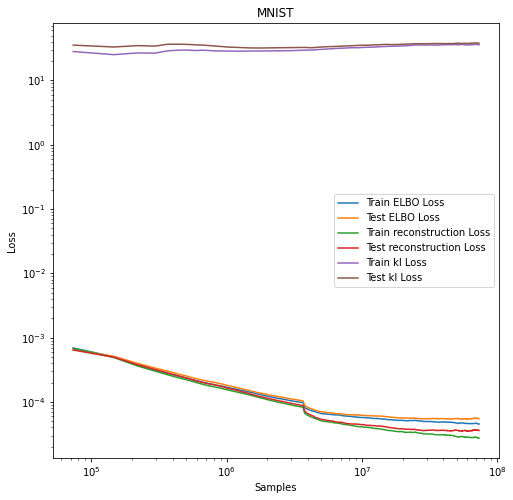

In [10]:
#drawing

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
        
import numpy as np
import pandas as pd

def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().values

def drawing():
    plt.clf()
    fig = plt.figure(figsize=(8, 8))
    trains = []
    trains_recon = []
    trains_kl = []
    tests = []
    tests_recon = []
    tests_kl = []
    with open('/root/fornewdata/SVHN/CVAE/loss.txt', 'r') as file:
        for line in file:
            parts = line.split()
            trains.append(float(parts[0]))
            trains_recon.append(float(parts[1]))
            trains_kl.append(float(parts[2]))
            tests.append(float(parts[3]))
            tests_recon.append(float(parts[4]))
            tests_kl.append(float(parts[5]))
            
    epochs = [len(train_dataset) * i for i in range(1, len(trains) + 1)]
    
    size = 100
    print("Reconstruction Loss: ", sum(trains_recon[-size:])/size)
    print("KL Loss: ", sum(trains_kl[-size:])/size)
    print("Reconstruction Loss: ", sum(tests_recon[-size:])/size)
    print("KL Loss: ", sum(tests_kl[-size:])/size)
    
    window_size = 50
    trains = moving_average(trains, window_size)
    tests = moving_average(tests, window_size)
    trains_recon = moving_average(trains_recon, window_size)
    tests_recon = moving_average(tests_recon, window_size)
    trains_kl = moving_average(trains_kl, window_size)
    tests_kl = moving_average(tests_kl, window_size)
    
    plt.plot(epochs, trains, label='Train ELBO Loss')
    plt.plot(epochs, tests, label='Test ELBO Loss')
    plt.plot(epochs, trains_recon, label='Train reconstruction Loss')
    plt.plot(epochs, tests_recon, label='Test reconstruction Loss')
    plt.plot(epochs, trains_kl, label='Train kl Loss')
    plt.plot(epochs, tests_kl, label='Test kl Loss')
    
    plt.xlabel('Samples')
    plt.ylabel('Loss')
    plt.title('MNIST')
    plt.legend()
    #plt.ylim(-150, -100)
    #plt.xlim(1e5, 1e8)
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('/root/fornewdata/SVHN/CVAE/pictures/train.png',bbox_inches='tight')
    plt.show()

drawing()